In [96]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp_rx }|\text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }|\text{rssi}}$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [97]:
# define the file name
filename = "logs/2023-03-30-12-01-41-2cc-70kbaud.txt"
# import file to jupyter notebook
df = readfile("./" + filename)
# check the imported data first 10 lines
df.head(10)

,index,time_rx,rssi,seq,payload
0,0,2023-03-30 00:00:28.064,-68,93,10 5c 24 32 1f df 13 48 14 7f 22 a7 24 30
1,1,2023-03-30 00:00:28.129,-67,94,10 68 1e ad 1f da 12 8b 12 0a 25 50 2b fe
2,2,2023-03-30 00:00:28.195,-67,95,10 74 2d 40 1d 99 19 5e 23 f3 11 46 29 70
3,3,2023-03-30 00:00:28.261,-67,96,10 80 19 fc 16 6f 1e a2 24 f6 2a 42 26 b2
4,4,2023-03-30 00:00:28.327,-68,97,10 8c 29 6a 1d bd 21 37 24 97 1c 6e 11 67
5,5,2023-03-30 00:00:28.393,-68,98,10 98 1d 99 18 4e 26 ef 2e 9d 0d 24 1c ca
6,6,2023-03-30 00:00:28.459,-66,99,10 a4 2b 36 13 fc 1e 7e 2b f9 28 1f 29 52
7,7,2023-03-30 00:00:28.525,-67,100,10 b0 13 b4 1d 3d 18 19 20 b5 21 10 2e 11
8,8,2023-03-30 00:00:28.591,-67,101,10 bc 18 0c 19 c7 29 dc 16 bd 26 28 1e e0
9,9,2023-03-30 00:00:28.657,-67,102,10 c8 18 ed 2f 72 18 d7 25 93 16 df 12 20


In [98]:
# delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
df.reset_index(inplace=True)

In [99]:
# replace the resettable seq number to unresettable, for the purpose of reliability calculation
test = replace_seq(df.copy(), MAX_SEQ=256)
test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [100]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:01:19.894000, which is 79.894 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ sent}$$
***
**Interesting to look at**:
1. *Expected number of transmission*: the ratio of the number of packets correctly received by the data sink and the number of packets sent by the source.

$$ETX = \frac{Number\ of\ packet\ received}{Number\ of\ packet\ sent}$$

2. *Packet reliability*: the number of packet bit correctly delivered to next hop.

## Statistics

In [101]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber, error, file_content = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
bit_reliability = (1-ber)*100
print(f"Bit reliability [%]: {bit_reliability}")

The total number of packets transmitted by the tag is 1820.
Error statistics dataframe is:
       seq bit_error_tmp  bit_error
0       93           [1]          1
1       94           [0]          0
2       95           [0]          0
3       96           [0]          0
4       97           [0]          0
...    ...           ...        ...
1722  1815           [0]          0
1723  1816           [0]          0
1724  1817           [0]          0
1725  1818           [0]          0
1726  1819           [0]          0

[1727 rows x 3 columns]
Bit reliability [%]: 68.60222447403976


In [102]:
# payload example for debug purpose
# correct sequence for pesudoseq NO. '0000'
tmp = file_content.loc[int('0000', base=16), 'data']
for i in tmp:
    print("{:02x}".format(i), end=" ")

13 5d 1f 43 1b 45 25 6f 21 fe 0f 7e 

Text(0.5, 0, 'Seq. Number')

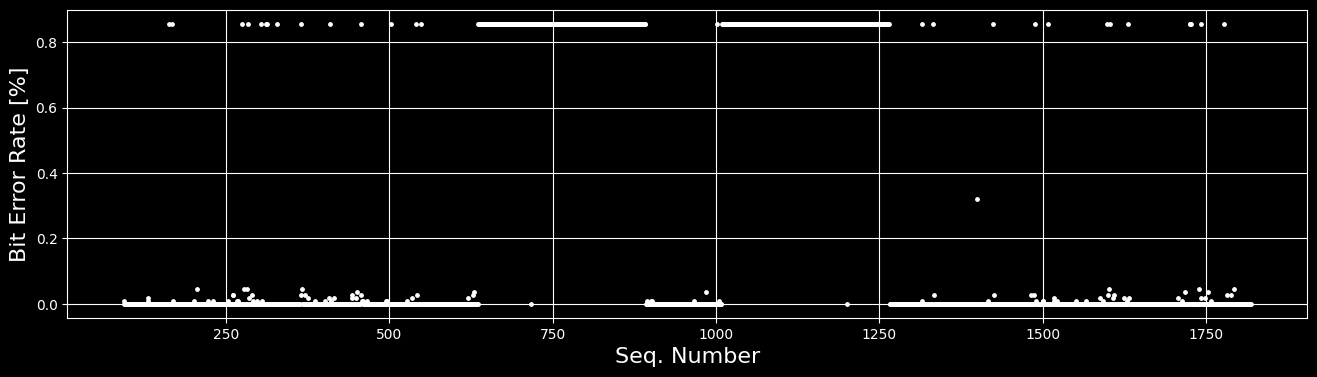

In [103]:
# BER for each packet
plt.scatter(error.seq, error.bit_error/(PAYLOADSIZE*8), marker='o', s=6, color='white')
plt.grid()
plt.ylabel('Bit Error Rate [%]', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [104]:
# record the distance
dis_carrier_tag = 1
dis_tag_rx = 4

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 16


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

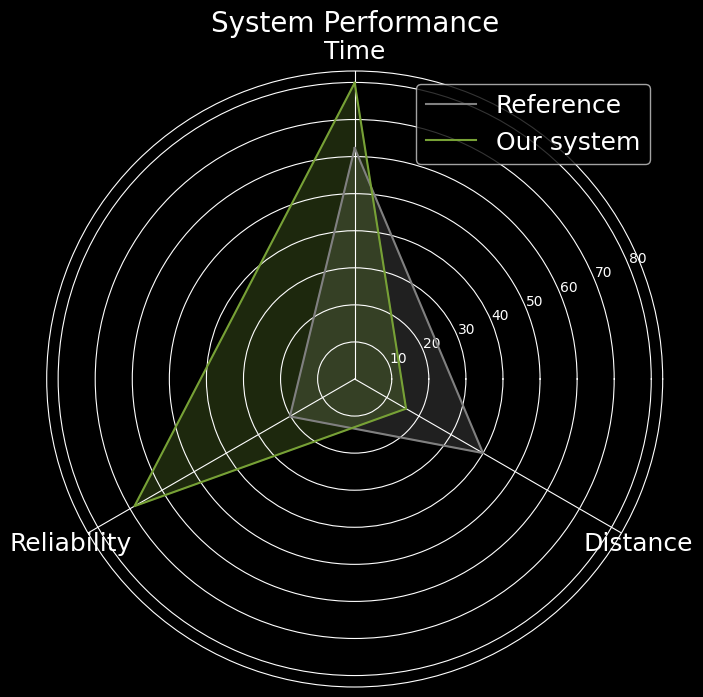

In [105]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)